# Overview

This project consists of three notebooks. Together the three notebooks build a neural network that evaluates the board position in chess.

The first notebook ParseData reads in the data in pgn format, converts it to binary vectors and then saves the formatted data. The second notebook NN builds a feedforward neural network that predicts the probability that a board position is win, draw or lose for white. The third notebook analyzes the formatted data. It performs some low-level and high-level checks that the data was formatted properly. It also outputs some graphs and statistics about the data. AWS is used to parse the data and train and test the neural network.

**Sections:**

1. Data Wrangling

2. Fit Neural Network

3. Test Neural Network

4. Final Graphs and Results

In [1]:
#load packages
import sys
sys.path.append("/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/")
import boto3
import numpy as np
import scipy as sp
from scipy.sparse import csr_matrix, coo_matrix
from scipy.sparse import vstack as vstack
import chess, chess.pgn
import time
import multiprocessing as mp
import os
import re
import pandas as pd
from datetime import datetime
import pickle
import gzip

In [2]:
# constants
BOARD_LENGTH = 768 #chess board is 8 x 8 and 12 different pieces

## Vector representation of chess board
# v = 1 x BOARD_LENGTH
#
# White = Upper Case, black = lower case
# Piece order: P, N, B, R, Q, K, p, n, b, r, q, k
# Board order:
#    Start at square a1. Move across the columns to square h1.
#    Then go up a row to square a2. Move across the columns to square h2.
#    Repeat until square h8
#    i.e. 0 - a1, 1 - b1, ..., 7 - h1, 8 - a2, ..., 63 - h8
#
# Board vector indices: 
# v[0,...,63] = P, v[64,...,127] = N, ..., v[704,...,767] = k
# v[0,...,7] = row 1; v[8,...,15] = row 2, ..., v[56,...,63] = row 8
# v[0] = col a, v[1] = col b, ..., v[7] = col h

PIECE_OFFSETS = {'P': 0, 'N': 64, 'B': 128, 'R': 192, 'Q': 256, 'K': 320,
                 'p': 384, 'n': 448, 'b': 512, 'r': 576, 'q': 640, 'k': 704}

RESULTS = {'1-0': 1,'1/2-1/2': 0,'0-1': -1}

# Data Wrangling

In this section, we read in the data and reformat it from chess portable game notation (pgn) to matrix form so that can the data can be fed through a neural network. Specifically, we convert each board position in each game into binary vectors encoded as above. The data is in 10 pgn files by year. We loop through the pgn files. For each pgn file, we open it and loop through the games. For each game, we encode all the board positions. In addition, we record statistics about the game (see below). The board positions are converted to a compressed sparse row matrix since the majority of the values are zero. Given any board position, there are at most 32 pieces, which means the density of the vector is at most 32/768 = 4.17%. We parallelize parsing the data using the multiprocess pacakge.

**Statistics About the Data**

1. Number of games
2. Shortest game, average game, longest game in terms of # of moves
3. Count of time controls
4. difference in ratings, min, ave, max
5. num of white wins, draws and loses

**References**

Portable Game Notation (PGN): https://en.wikipedia.org/wiki/Portable_Game_Notation

Forsyth–Edwards Notation (FEN): https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation

In [3]:
# functions to help parse pgn files

def convertBoardToVec(board):
    '''convertBoardToVec(board object) -> array
        
        board object = object of Board Class from chess,
        array = 1d np array of length BOARD_LENGTH
        
    This function loops converts a board to its corresponding vector representation
    '''
    
    v = np.zeros(BOARD_LENGTH, dtype = np.int8)

    pieces = board.piece_map()
    for sq in pieces:
        piece = pieces[sq]
        ind = PIECE_OFFSETS[piece.symbol()] + sq
        v[ind] = 1
        
    return(v)

def parseGame(game):
    '''parseGame(game object) -> (sparse matrix, np.array, list)
        
        game object = object of Game class from chess,
        sparse matrix = scipy csr matrix encoding the sequence of board positions,
        np.array = numpy array of result of game
        list = length 4, statistics about the game
        
    This function loops through the moves in a game and
    converts the sequence of board positions to a sparse matrix.
    In addition returns statistics about the game.
    Returns (None, None, None) if game has no half moves.
    '''
    
    board = game.board()
    
    #default values
    boardMatrix = None
    resultMatrix = None
    stats = [0]*4
    boardList = []
    
    mainLine = game.main_line()
    for i, halfMove in enumerate(mainLine): #mainLine is a generator object
        
        if i == 0:
            # get stats about game from headers
            try:
                h = game.headers
                stats[0] = int(h['PlyCount'])
                clock = h['WhiteClock']
                if clock.count(':') == 2:
                    stats[1] = int(datetime.strptime(clock,'%H:%M:%S.%f').minute)
                else:
                    stats[1] = int(datetime.strptime(clock,'%M:%S.%f').second/60)
                    
                stats[2] = int(h['WhiteElo']) - int(h['BlackElo'])
                stats[3] = RESULTS[h['Result']]
            except (KeyError, TypeError, ValueError):
                continue
                #stats = [np.nan]*4
        
        # convert sequence of board positions into 2-d binary array
        board.push(halfMove)
        #combine board vector with result
        boardList.append(convertBoardToVec(board))
    
    if boardList != []:
        boardMatrix = csr_matrix(np.stack(boardList, axis = 0), dtype=np.int8) #sparse array
        resultMatrix = np.full((boardMatrix.shape[0],1), stats[3], dtype=np.int8)
        #M = np.stack(boardList, axis = 0) #dense array
    
    return(boardMatrix, resultMatrix, stats)

def parseChunk(outFile, pgnFile, chunkInfo, chunkNum):
    '''returns list of length 2 [boardMatrix, gameStats]
    
    pgnFile - str: name of pgn file to parse
    chunkInfo - 3-stuple of ints: (startingGameNum, startingOffset, totGames)
    chunkNum - int: chunk number
    boardMatrix - sparse array: sparse matrix of the enconded board positions
    gameStats - information from the headers about each game
    
    This function parse the section of games in the pgn file specified in chunkInfo
    '''
    
    handle = open(pgnFile)
    
    # unpack tuple
    startingGameNum, startingOffset, totGames = chunkInfo
    
    # change file object's position 
    handle.seek(startingOffset)
    
    # pandas dataframe to store statistics about the data
    gamesStats = pd.DataFrame(data = 0, index = range(startingGameNum, startingGameNum + totGames),
                             columns = ['Moves','Clock','RatingDiff','Result'])
    
    # sparse matrix to hold sequence of boards from all games
    gamesMat = csr_matrix((0, BOARD_LENGTH), dtype = np.int8)
    
    #numpy array to hold result
    gamesRes = np.zeros((0,1), dtype = np.int8)
    
    # read and parse games
    for i in range(startingGameNum, startingGameNum + totGames):
        # read in game
        game = chess.pgn.read_game(handle)

        # get sparse matrix, result and stats for game
        gameMat, gameRes, gameStats = parseGame(game)
 
        # save
        if gameMat != None:
            gamesMat = vstack([gamesMat, gameMat], format = 'csr')
            gamesRes = np.vstack([gamesRes,gameRes])
            gamesStats.loc[i,:] = gameStats

    handle.close()
    
    # save processed chunk
    outMat = outFile.rstrip('.pgn') + '_' + str(chunkNum) + '_mat.pickle.gz'
    outStats = outFile.rstrip('.pgn') + '_' + str(chunkNum) + '_stats.pickle'
    
    with gzip.open(outMat, 'wb') as f:
        f.write(pickle.dumps([gamesMat,gamesRes], pickle.HIGHEST_PROTOCOL))
    
    gamesStats.to_pickle(outStats)
    
    return

def parseFile(pgnFile, outFile, numChunks = 4):
    '''Saves two files - one for the vector of board positions and one for the game stats
    
    pgnFile - str: path to pgn file
    '''

    # get info about how to split up file into chunks
    chunkInfo = prepareFile(pgnFile, numChunks)
    chunkList = [(outFile, pgnFile, chunkInfo[i], i) for i in range(numChunks)]
    
    # parse file by chunk
    workers = mp.Pool(processes = numChunks)
    workers.starmap_async(parseChunk, chunkList, numChunks)
    workers.close()
    workers.join()
    
    return
    
def prepareFile(pgnFileName, nChunks, nGames = 500000):
    '''prepareFile(fileName, nChunks, nGames) -> list of length n of 3-tuples
    
    pgnFileName - str: name of the pgn file to split into n chunks
    nChunks - int: number of chunks to break file into
    nGames - int: upper bound on number of games in the file
    tuple - (int, int, int): (startingGameNum, startingOffset, totGames)
    '''
    
    pgnFile = open(pgnFileName)
    
    # get game numbers and offsets
    totGames = 0
    offsets = np.empty(nGames, dtype = np.int_)
    
    for offset in chess.pgn.scan_offsets(pgnFile):
        totGames = totGames + 1
        offsets[totGames - 1] = offset
    
    chunkSize = totGames // nChunks
    tail = int(totGames - chunkSize * nChunks)
    
    l = []
    for i in range(nChunks - 1):
            l.append((i * chunkSize + 1, offsets[i * chunkSize], chunkSize))

    l.append(((nChunks - 1) * chunkSize + 1, offsets[(nChunks - 1) * chunkSize], chunkSize + tail))
    
    pgnFile.close()
    
    return(l)

def main(inDataDir, outDataDir):
    
    workers = []
    
    inDataFiles = os.listdir(inDataDir)
    
    for inDataFile in inDataFiles:
        if inDataFile.endswith('.pgn'):
            inFile = os.path.join(inDataDir, inDataFile)
            outFile = os.path.join(outDataDir, inDataFile)
            
            worker = mp.Process(target = parseFile, args = (inFile, outFile)) #, daemon = False        
            worker.start()
            workers.append(worker)
    
    for w in workers:
        w.join()

In [4]:
if __name__ == '__main__':
    inDataDir = '../sample/raw'
    outDataDir = '../sample/clean'
    
    #s = time.time()
    #main(inDataDir, outDataDir)
    #e = time.time()
    #print("Total time to process {}".format(e - s))

In [6]:
inDataFiles = os.listdir(inDataDir)
    
for inDataFile in inDataFiles:
    if inDataFile.endswith('.pgn'):
        inFile = os.path.join(inDataDir, inDataFile)

In [8]:
pgnFile = open(inFile)

In [9]:
game = chess.pgn.read_game(pgnFile)

In [18]:
board = game.board()

In [19]:
mainLine = game.main_line()

In [46]:
board.push(next(mainLine))

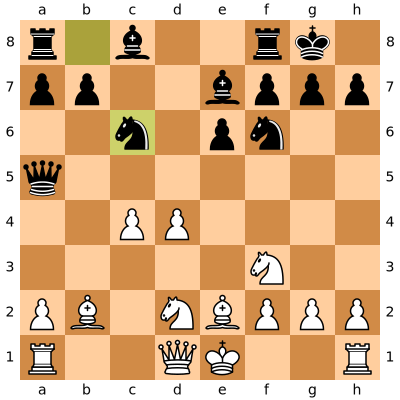

In [47]:
board

In [48]:
v = convertBoardToVec(board)

In [54]:
(v == 1) * np.arange(768)

array([  0,   0,   0,   0,   0,   0,   0,   0,   8,   0,   0,   0,   0,
        13,  14,  15,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        26,  27,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  75,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  85,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0, 137,   0,   0, 140,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [40]:
# decouple: create info about chunks using multiple cores, then take info about chunks and process using multiple cores

# Notes for Report

1. Vector encoding of board positions
2. Storage saving from using compressed sparse row matrices
3. Estimate of time to read 2007 data based on first 1000 games
4. Parallel processing of the data
5. graphs - % of white wins, black wins and draws
6. scatter plot rating diff and white win %
7. num og games, ave moves per game
8. randomly check 10 board positions and compare with printed board,
   - max # of 1s for all the boards, ave and min
   - sum of moves = num of rows in sparse matrix
9. reading first 10,000 games, serial vs parallel

**Notes on data**

1. Didn't use games between low rated players because low rated players could have relationships that are bad to learn
    for example, a if white is up a rook, this position should lead to a win 99%+ of the time, but with bad players this position might lead to a win only 50% of the time because bad players blunder a lot
2. further training = neural net plays against itself and one of the player's make a mistake occassionally
3. skill level game = sum of 2 players and use this as a weight, rating diff between players
4. not super predictable playing style from comp

# Utility Functions

This section contains functions that gather information about the execution of the main code

In [ ]:
# calculates time for function to execute
# look up profiling python like a boss

In [ ]:
def readGame(pgnFileH):
    '''readGame(handle to pgn file) -> next game object
    
    Generator function that creates iterator to loop through games
    '''
    
    game = chess.pgn.read_game(pgnFileH)
    while game != None:
        yield game
        game = chess.pgn.read_game(pgnFileH)
        
def readGame2(pgnFile, gameNum, gameOffset):
    '''random access version of read game - for parallel processing
    
    pgnGames - handle to pgn file
    gameNum - game number
    gameOffset - file offset
    '''
    
    # move to location in file and read in game
    pgnGames = open(pgnFile)
    pgnGames.seek(gameOffset)
    game = chess.pgn.read_game(pgnGames)
    
    # get sparse matrix and stats for game
    gameMat, gameStats = parseGame(game)  
    
    return((gameMat, gameStats, gameNum))
        
def readGames(pgnFileH):
    '''readGames(handle to pgn file) -> tuple (sparse matrix of all games, dataframe of stats)
    '''
    
    # pandas dataframe to store statistics about the data
    # at most 1 M per year based on skimming through the largest file 2013
    dataStats = pd.DataFrame(data = 0, index = range(3*10**4),
                             columns = ['Moves','Clock','RatingDiff','Result'])
    
    # sparse matrix to hold sequence of boards from all games
    gamesMat = csr_matrix((0, BOARD_LENGTH + 1), dtype = np.int8)
    
    for i, game in enumerate(readGame(pgnFileH)):
            
        # get sparse matrix and stats for game
        gameMat, gameStats = parseGame(game)
        
        # add game matrix and game stats to matrix and dataframe for all games
        if gameMat != None:
            gamesMat = vstack([gamesMat, gameMat], format = 'csr')
            dataStats.iloc[i,:] = gameStats
        
    return(gamesMat, dataStats.iloc[0:i,:])

In [8]:
inDataDir = '../sample/raw'

inDataFiles = os.listdir(inDataDir)
    
for inDataFile in inDataFiles:
    if inDataFile.endswith('.pgn'):
        inFile = os.path.join(inDataDir, inDataFile)

In [10]:
t=0
pgnFile = open(inFile)
for offset in chess.pgn.scan_offsets(pgnFile):
        t=t+1
pgnFile.close()

In [11]:
227792

227792

In [ ]:
# parallelize processing of data
# uses multiprocessing library from python standard libaray
# pool of 4 workers (processes) are created
# asynchronous calls to games in the pgn file are spread out among the 4 workers
# call = read and parse a particular game
# 
#                         -> worker1 -> parse game into sparse matrix and stats |
#   pgn file -> read game -> worker2 -> "                                     " |  -> container
#                         -> worker3 -> "                                     " |           
#                         -> worker4 -> "                                     " |


# pandas dataframe to store statistics about the data
# at most 1 M per year based on skimming through the largest file 2013
#gStats = pd.DataFrame(data = 0, index = range(10**6), columns = ['Moves','Clock','RatingDiff','Result'])
# sparse matrix to hold sequence of boards from all games
#gMat = csr_matrix((0, BOARD_LENGTH + 1), dtype = np.int8)



# AWS

In [ ]:
s3 = boto3.client('s3')

In [ ]:
s3.create_bucket(Bucket='brianlubeck', CreateBucketConfiguration={'LocationConstraint': 'us-west-1'})

In [ ]:
# uploads the given file using a managed uploader, which will split up large
# files automatically and upload parts in parallel.
# uncomment code 
for i, f in enumerate(pgnFiles[4:]):
    fn = 'chess/data/' + str(2011 + i) + '.pgn'
    s3.upload_file(f, 'brianlubeck2', fn)

In [ ]:
a = np.zeros((0,1), dtype=np.int8)

In [ ]:
b = np.vstack((a,[-1]))

In [ ]:
np.vstack([b,None]).shape